# mesoSPIM PSF-analysis

Currently, this analysis notebook needs a stack with beads converted to `.tif`-files. pixel-size and zoom have to be set manually.

### Setup environment

In [1]:
import numpy as np
import pandas as pd
from skimage.io import imread, find_available_plugins
import time

In [2]:
#from psf import plotPSF #, compute

### Setup plotting

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')

In [4]:
from ipywidgets import interact
from ipywidgets import IntSlider

### Define parameters

`windowUm = [12, 10, 10]` defines a "window" volume in microns in which only a single bead can exist (for the bead to be included in the analysis, the volume has to contain a single bright maximum).

In [5]:
# Full FOV 
MAG = 2 # Mitu 2X 
TL_f_mm = 180 # Olympus TL
eff_MAG = MAG * TL_f_mm/200
FOVpxLat = 100 # Iris 15: 2960.0
UmPerPxLat = 4.25/eff_MAG
pxPerUmLat = 1/UmPerPxLat
FOVumLat = FOVpxLat / pxPerUmLat
pxPerUmAx = 1.0 # between z-planes
windowUm = [10, 10, 10] # 
options = {'FOVumLat':FOVumLat, 'FOVpxLat':FOVpxLat, 'pxPerUmLat':FOVpxLat/FOVumLat, 'pxPerUmAx':pxPerUmAx, 'windowUm':windowUm}
options['thresh'] = 700 #changed from 0.05

In [6]:
options

{'FOVumLat': 236.11111111111111,
 'FOVpxLat': 100,
 'pxPerUmLat': 0.4235294117647059,
 'pxPerUmAx': 1.0,
 'windowUm': [10, 10, 10],
 'thresh': 700}

In [7]:
datafolder = "D:\\benchtopData\\PSF\\"
LENS_NAME = f"Mitutoyo BD {MAG}x/0.14 TLf{TL_f_mm}"
CAMERA = "Photometrics Iris 15"
sensor_dim_mm = (21.49, 12.61) # Iris 15
freq_Hz = 99.9
exp_ms = 20
experiment_key = f"{MAG}test-corner" #should start with magnification. e.g. 2
suffix = ''
datafiles = {
    f"{MAG}scanned": datafolder + f"2022-09-20-Fbright200um-2XMitutoy-TL_Olympus\\488-2X_Mitu(TL-Olympus)-scanned.tif",
    f"{MAG}test-center": datafolder + f"2022-09-20-Fbright200um-2XMitutoy-TL_Olympus\\test-mini-stack-scanned-1.tif",
    f"{MAG}test-corner": datafolder + f"2022-09-20-Fbright200um-2XMitutoy-TL_Olympus\\test-mini-stack-scanned-2.tif",
}


### Load data

In [8]:
im = imread(datafiles[experiment_key], plugin='tifffile')[:50]
im.shape

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


(50, 300, 200)

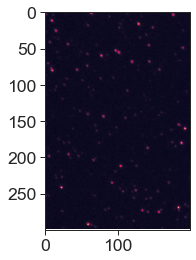

In [60]:
plt.imshow(im[1,:,:])

### Computation

In [9]:
from numpy import all, asarray, array, where, exp
from pandas import DataFrame
from skimage.filters import gaussian, median
from skimage.feature import peak_local_max
from scipy.optimize import curve_fit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

def compute(im, options):
    beads, maxima, centers, smoothed = getCenters(im, options)
    return [getPSF(x, options) for x in beads], beads, maxima, centers, smoothed

def inside(shape, center, window):
    """
    Returns boolean if a center and its window is fully contained
    within the shape of the image on all three axes
    """
    return all([(center[i]-window[i] >= 0) & (center[i]+window[i] <= shape[i]) for i in range(0,3)])

def volume(im, center, window):
    if inside(im.shape, center, window):
        volume = im[(center[0]-window[0]):(center[0]+window[0]), (center[1]-window[1]):(center[1]+window[1]), (center[2]-window[2]):(center[2]+window[2])]
        volume = volume.astype('float64')
        baseline = volume[[0,-1],[0,-1],[0,-1]].mean()
        volume = volume - baseline
        volume = volume/volume.max()
        return volume

def getPSF(bead, options):
    latProfile, axProfile = getSlices(bead)
    latFit = fit(latProfile,options['pxPerUmLat'])
    axFit = fit(axProfile,options['pxPerUmAx'])
    data = DataFrame([latFit[3], axFit[3]],index = ['FWHMlat', 'FWHMax']).T
    return data, latFit, axFit

def getSlices(average):
    latProfile = (average.mean(axis=0).mean(axis=1) + average.mean(axis=0).mean(axis=1))/2
    axProfile = (average.mean(axis=1).mean(axis=1) + average.mean(axis=2).mean(axis=1))/2
    return latProfile, axProfile

def fit(yRaw,scale):
    y = yRaw - (yRaw[0]+yRaw[-1])/2
    x = (array(range(y.shape[0])) - y.shape[0]/2)
    x = (array(range(y.shape[0])) - y.shape[0]/2)
    popt, pcov = curve_fit(gauss, x, y, p0 = [1, 0, 1, 0])
    FWHM = 2.355*popt[2]/scale
    yFit = gauss(x, *popt)
    return x, y, yFit, FWHM

def plotPSF(x,y,yFit,FWHM,scale,Max):
    plt.plot(x.astype(float)/scale,yFit/yFit.max(), lw=2);
    plt.plot(x.astype(float)/scale,y/yFit.max(),'ok');
    plt.xlim([-x.shape[0]/2/scale, x.shape[0]/2/scale])
    plt.ylim([0, 1.1])
    plt.xlabel('Distance (um)')
    plt.ylabel('Norm. intensity')
    plt.annotate('FWHM %.2f um' % FWHM,xy=(x.shape[0]/4/scale, .6), size=14)
    plt.annotate('Brightness %.2f' % Max,xy=(x.shape[0]/4/scale, .5), size=14)


def plotAvg(i):
    plt.figure(figsize=(5,5));
    plt.imshow(average[i], vmin=0, vmax=.9);
    if i==average.shape[0]/2:
        plt.plot(average.shape[1]/2, average.shape[2]/2, 'r.', ms=10);
    plt.xlim([0, average.shape[1]])
    plt.ylim([average.shape[2], 0])
    plt.axis('off');

def plotAvg(i):
    plt.figure(figsize=(5,5));
    plt.imshow(average[i], vmin=0, vmax=.9);
    if i==average.shape[0]/2:
        plt.plot(average.shape[1]/2, average.shape[2]/2, 'r.', ms=10);
    plt.xlim([0, average.shape[1]])
    plt.ylim([average.shape[2], 0])
    plt.axis('off');

def dist(x,y):
    return ((x - y)**2)[1:].sum()**(.5)

def nearest(x,centers):
    z = [dist(x,y) for y in centers if not (x == y).all()]
    return abs(array(z)).min(axis=0)

def gauss(x, a, mu, sigma, b):
    return a*exp(-(x-mu)**2/(2*sigma**2))+b


In [10]:
from skimage.morphology import cube, disk
def findBeads(im, window, thresh, min_distance=1):
    '''
    Uses a 2D gaussian filter to smooth the data with a sigma of 1
    Finds peaks that are at least separated by min distance

    Returns the max projection of the smoothed image
    '''
    smoothed = gaussian(im, 1, output=None, mode='nearest', preserve_range=True)
    #smoothed = median(im, cube(3), mode='reflect')
    centers = peak_local_max(smoothed, min_distance=min_distance, threshold_abs=thresh, exclude_border=True)
    print(f'findBeads() done: {len(centers)} found')
    return centers, smoothed.max(axis=0)

In [11]:
def getCenters(im, options):
    window = [options['windowUm'][0]*options['pxPerUmAx'], options['windowUm'][1]*options['pxPerUmLat'], options['windowUm'][2]*options['pxPerUmLat']]
    window = [round(x) for x in window]
    centers, smoothed = findBeads(im, window, options['thresh'])
    centers = keepBeads(im, window, centers, options)
    beads = [volume(im, x, window) for x in centers]
    maxima = [im[x[0], x[1], x[2]] for x in centers]
    print(f'getCenters() done: {len(centers)} found')
    return beads, maxima, centers, smoothed

In [15]:
def keepBeads(im, window, centers, options):
    centersM = asarray([[x[0]/options['pxPerUmAx'], x[1]/options['pxPerUmLat'], x[2]/options['pxPerUmLat']] for x in centers])
    centerDists = [nearest(x,centersM) for x in centersM]
    #min_distance = sum([x**2 for x in options['windowUm']])**(.5)
    min_distance = min(options['windowUm'])
    keep = where([x > min_distance for x in centerDists])
    centers = centers[keep[0],:]
    keep = where([inside(im.shape, x, window) for x in centers]) # window inside the stack
    print(f'keepBeads() done: {len(keep[0])} found')
    return centers[keep[0],:]

In [13]:
window = [options['windowUm'][0]*options['pxPerUmAx'], options['windowUm'][1]*options['pxPerUmLat'], options['windowUm'][2]*options['pxPerUmLat']]
window = [round(x) for x in window]
window

[10, 4, 4]

In [67]:
centers, smoothed = findBeads(im, window, options['thresh'])
len(centers)

427

In [68]:
centers_keep = keepBeads(im, window, centers, options)
centers_keep.shape

(67, 3)

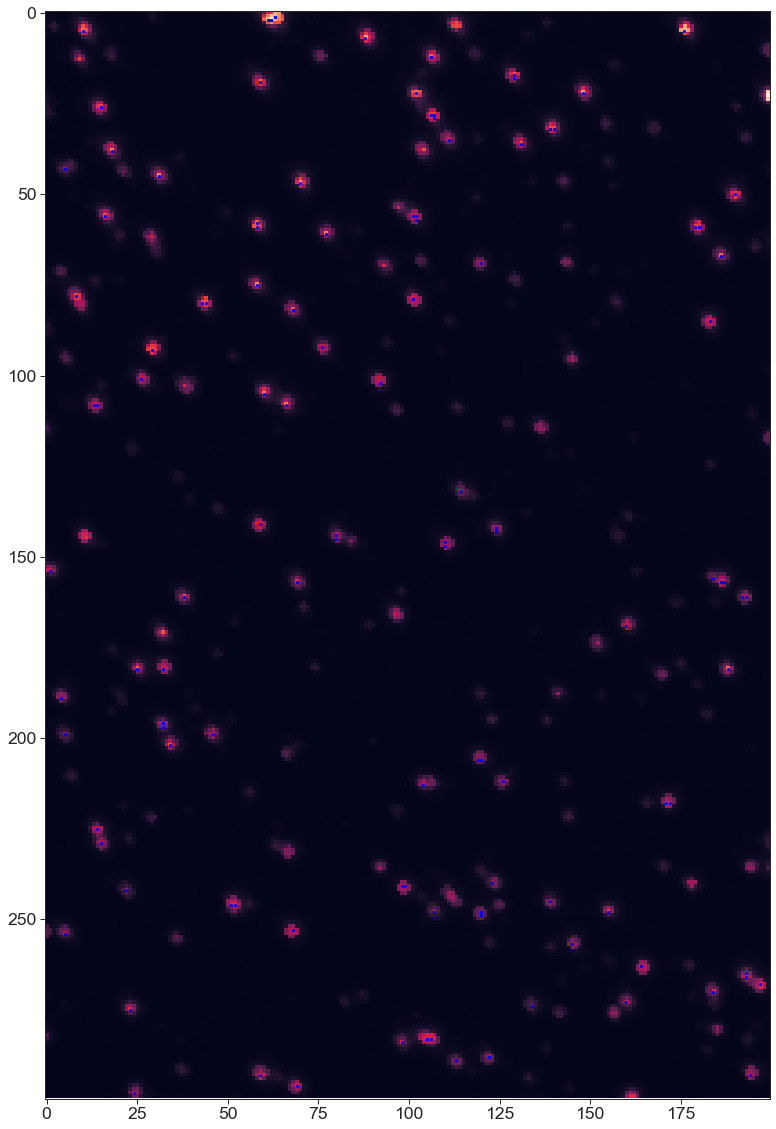

In [48]:
plt.figure(figsize=(20,20))
plt.imshow(smoothed)
plt.plot(centers[:,2], centers[:,1], 'b.', ms=4);
#plt.plot(centers_keep[:,2], centers_keep[:,1], 'b.', ms=5);

In [16]:
start_time = time.time()
data, beads, maxima, centers, smoothed = compute(im, options)
stop_time = time.time()
print('Runtime: ',stop_time-start_time, ' s')

findBeads() done: 252 found
keepBeads() done: 128 found
getCenters() done: 128 found
Runtime:  0.8204634189605713  s


In [79]:
len(beads)

128

In [80]:
centers = pd.DataFrame(centers, columns=['Z','Y','X'])

In [81]:
PSF = pd.concat([x[0] for x in data])
PSF['Max'] = maxima
PSF = PSF.reset_index().drop(['index'],axis=1)
latProfile = [x[1] for x in data]
axProfile = [x[2] for x in data]
PSF = PSF.join(centers)

### Inspect results

In [73]:
PSF.head()

,FWHMlat,FWHMax,Max,Z,Y,X
0,6.084521,4.665853,2495,40,13,47
1,5.439587,3.428656,2153,22,44,21
2,5.816542,3.920353,3059,26,12,18
3,5.967820,3.253443,2648,38,71,151
4,5.593862,9.154703,2222,10,7,88


In [74]:
print('# Beads: ', len(PSF))
print('Median lateral FWHM (+/- std): ', round(np.median(PSF['FWHMlat']),2), ' +/- ', round(PSF['FWHMlat'].std(),2), ' μm')
#print('STD lateral FWHM: ', round(PSF['FWHMlat'].std(),3))
print('Median axial FWHM  (+/- std): ', round(np.median(PSF['FWHMax']),2), ' +/- ', round(PSF['FWHMax'].std(),2), ' μm')
#print('STD axial FWHM: ', round(PSF['FWHMax'].std(),3))

print('Watch for large STD (>2 um), they indicate bad detections.')

# Beads:  67
Median lateral FWHM (+/- std):  5.67  +/-  0.58  μm
Median axial FWHM  (+/- std):  4.64  +/-  1.6  μm
Watch for large STD (>2 um), they indicate bad detections.


### Plot axial FWHM vs. FOV

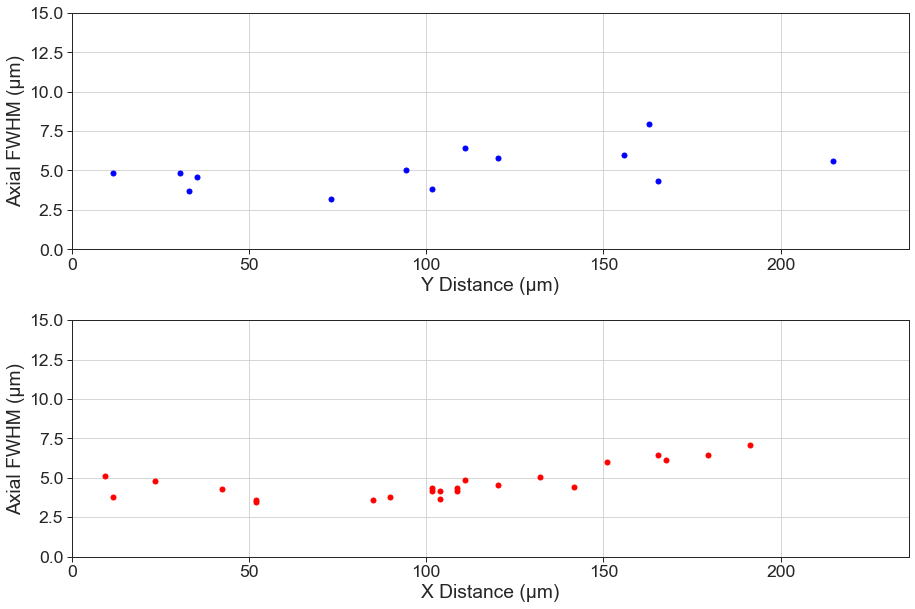

In [293]:
%matplotlib inline
fig = plt.figure(figsize=(15,10));

subfigure0 = fig.add_subplot(211)
subfigure0.plot(np.multiply(PSF['Y'].tolist(),UmPerPxLat),PSF['FWHMax'].tolist(),'.b',ms=10)
subfigure0.set_xlim([0,options['FOVumLat']])
subfigure0.set_ylim([0,15])
subfigure0.set_xlabel('Y Distance (μm)')
subfigure0.set_ylabel('Axial FWHM (μm)')
subfigure0.grid()

subfigure1 = fig.add_subplot(212)
subfigure1.plot(np.multiply(PSF['X'].tolist(),UmPerPxLat),PSF['FWHMax'].tolist(),'.r',ms=10)
subfigure1.set_xlim([0,options['FOVumLat']])
subfigure1.set_ylim([0,15])
subfigure1.set_xlabel('X Distance (μm)')
subfigure1.set_ylabel('Axial FWHM (μm)')
subfigure1.grid()

plt.subplots_adjust(hspace = 0.3)

### Save data and plots

In [179]:
PSF.to_csv('results/withoutETL-20ms-199hz-2x.csv')

In [180]:
fig.savefig('results/withoutETL-20ms-199Hz-4x-ETL-Comparision.svg', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)
fig.savefig('results/withoutETL-20ms-199Hz-4x-ETL-Comparision.jpg', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)

## Sanity checks

### Plot max projection and detected beads

In [29]:
smoothed.shape

(300, 200)

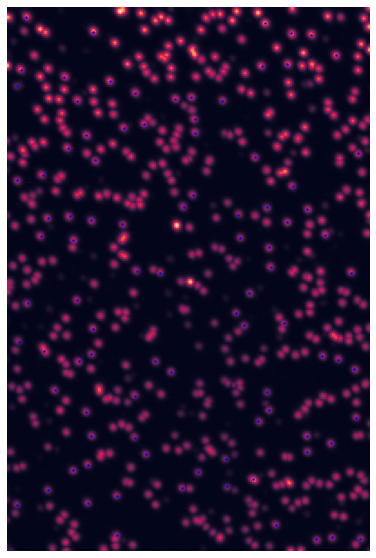

In [31]:
plt.figure(figsize=(10,10));
plt.imshow(smoothed);
plt.plot(PSF['X'].tolist(), PSF['Y'].tolist(), 'b.', ms=3);
plt.axis('off'); 

### Axial and lateral FWHM Histogram

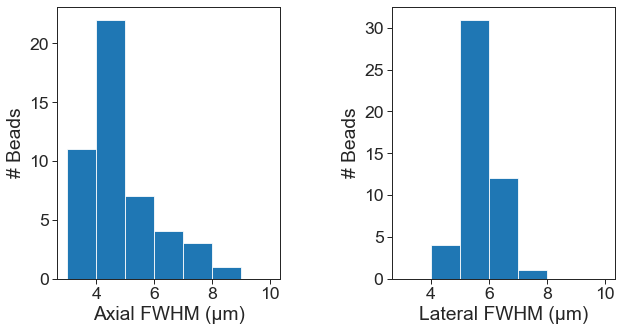

In [294]:
fig = plt.figure(figsize=(10,5))
subfigure0 = fig.add_subplot(121)
subfigure0.hist(PSF['FWHMax'].tolist(),7,range=(3,10))
subfigure0.set_xlabel('Axial FWHM (μm)')
subfigure0.set_ylabel('# Beads')
subfigure1 = fig.add_subplot(122)
subfigure1.hist(PSF['FWHMlat'].tolist(),7,range=(3,10))
subfigure1.set_xlabel('Lateral FWHM (μm)')
subfigure1.set_ylabel('# Beads')

plt.subplots_adjust(wspace = 0.5)

### Overview Plots

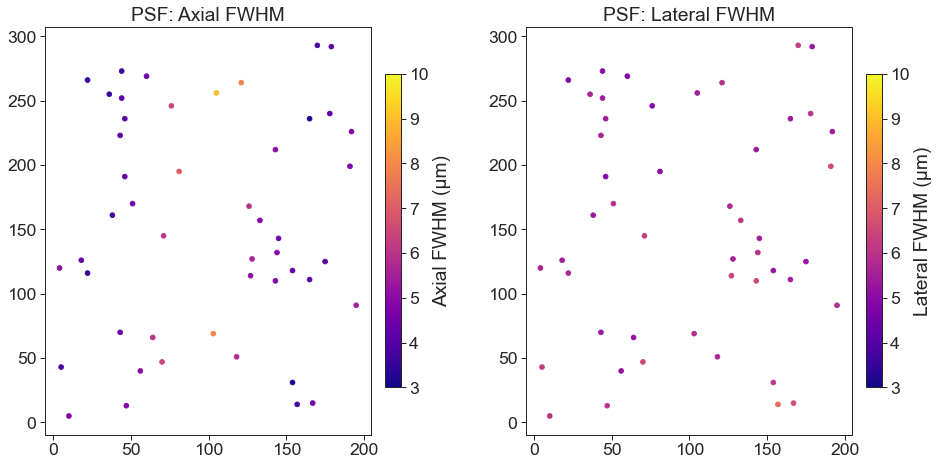

In [296]:
fig = plt.figure(figsize=(15,7.5));
cmap = 'plasma'

subfigure0 = fig.add_subplot(121)
overlay0 = subfigure0.scatter(PSF['X'].tolist(), PSF['Y'].tolist(), c=PSF['FWHMax'].tolist(), cmap=cmap, vmin=3, vmax=10)
subfigure0.axis('on');
subfigure0.set_title('PSF: Axial FWHM')
cbar0 = plt.colorbar(overlay0,fraction=0.044, pad=0.04)
cbar0.set_label('Axial FWHM (μm)')


subfigure1 = fig.add_subplot(122)
overlay1 = subfigure1.scatter(PSF['X'].tolist(), PSF['Y'].tolist(), c=PSF['FWHMlat'].tolist(), cmap=cmap, vmin=3, vmax=10);
subfigure1.axis('on');
subfigure1.set_title('PSF: Lateral FWHM')
cbar1 = plt.colorbar(overlay1,fraction=0.044, pad=0.04)
cbar1.set_label('Lateral FWHM (μm)')

plt.subplots_adjust(wspace = 0.35)

In [182]:
fig.savefig('results/withoutETL-20ms-199Hz-4x-ETL-Comparision_XYplot-improved-colors.svg', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)
fig.savefig('results/withoutETL-20ms-199Hz-4x-ETL-Comparision_XYplot-improved-colors.jpg', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)

###  Subselecting a dataframe

In [297]:
centerPSFs = PSF[PSF.FWHMlat > 10]
centerPSFs

,FWHMlat,FWHMax,Max,Z,Y,X


### Plot XYZ projections and fit

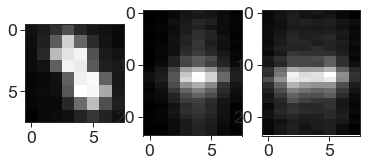

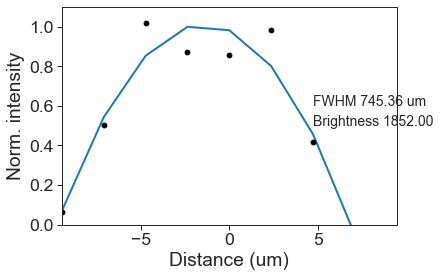

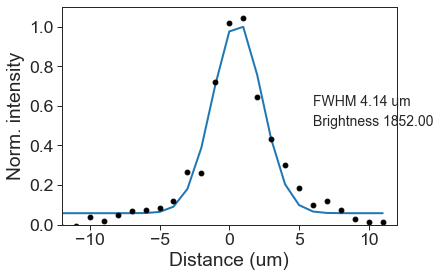

In [200]:
# Plot PSF with known ID
beadInd = 11
average = beads[beadInd]

fig, _axs = plt.subplots(nrows=1, ncols=3)
axs = _axs.flatten()

XYview = axs[0].imshow(average.mean(axis=0), cmap='gray');
XZview = axs[1].imshow(average.mean(axis=1), aspect = pxPerUmLat/pxPerUmAx, cmap='gray');
YZview = axs[2].imshow(average.mean(axis=2), aspect = pxPerUmLat/pxPerUmAx, cmap='gray');
plt.show()

plotPSF(latProfile[beadInd][0],latProfile[beadInd][1],latProfile[beadInd][2],latProfile[beadInd][3],pxPerUmLat,PSF.Max.iloc[beadInd])
plt.show()
plotPSF(axProfile[beadInd][0],axProfile[beadInd][1],axProfile[beadInd][2],axProfile[beadInd][3],pxPerUmAx,PSF.Max.iloc[beadInd])
plt.show()

In [171]:
fig = plt.figure()

def update(w = 50):
    beadInd = w
    average = beads[beadInd]
    
    fig, _axs = plt.subplots(nrows=1, ncols=3)
    axs = _axs.flatten()

    XYview = axs[0].imshow(average.mean(axis=0));
    XZview = axs[1].imshow(average.mean(axis=1), aspect = pxPerUmLat/pxPerUmAx);
    YZview = axs[2].imshow(average.mean(axis=2), aspect = pxPerUmLat/pxPerUmAx);
    plt.show()
    plotPSF(latProfile[beadInd][0],latProfile[beadInd][1],latProfile[beadInd][2],latProfile[beadInd][3],pxPerUmLat,PSF.Max.iloc[beadInd])
    plt.show()
    plotPSF(axProfile[beadInd][0],axProfile[beadInd][1],axProfile[beadInd][2],axProfile[beadInd][3],pxPerUmAx,PSF.Max.iloc[beadInd])
    plt.show()

interact(update, w=IntSlider(min=0,max=len(PSF)-1,step=1,value=0,continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='w', max=613), Output()), _dom_classes=('widget-interact',))